# Задание

1) Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.2) 
Приблизьте оба варианта моделями из класса MA
3) 
Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [5]:
files = os.listdir('Series')
print(*files, sep='\n')

daily-total-female-births-in-cal.csv
international-airline-passengers.csv
mean-monthly-air-temperature-deg.csv
monthly-boston-armed-robberies-j.csv
monthly-sales-of-company-x-jan-6.csv
weekly-closings-of-the-dowjones-.csv


1) В качестве стационарного ряда возьмем данные по рождениям девочек в Калифорнии, а в качестве нестационарного - данные по количеству пассажиров международного аэропорта.

<Axes: >

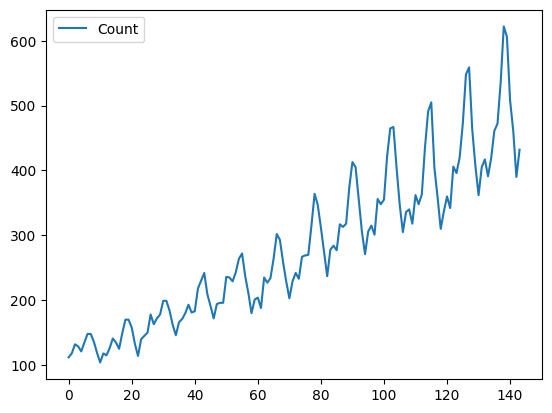

In [34]:
nst = pd.read_csv('Series/international-airline-passengers.csv')
nst.plot()

<Axes: >

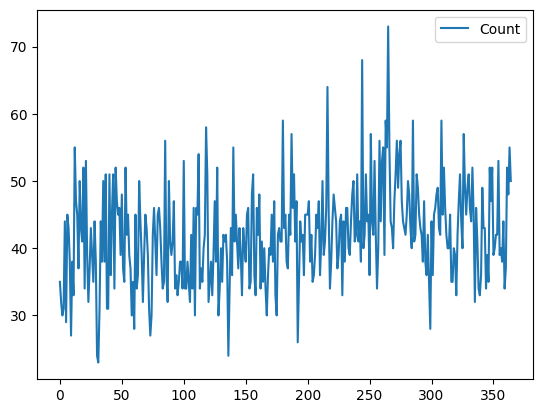

In [13]:
st = pd.read_csv('Series/daily-total-female-births-in-cal.csv')
st.plot()

2.а) Усредним стационарный временной ряд при помощи DEMA.

In [24]:
def double_ema(series, alpha, beta):
    result = [series.iloc[0]]
    level, trend = series.iloc[0], series.iloc[1] - series.iloc[0]
    for n in range(1, len(series)):
        value = series.iloc[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [31]:
def plot_dema(data, alpha, beta):
    dema = double_ema(pd.Series(data['Count']), alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(pd.Series(data['Count']), color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

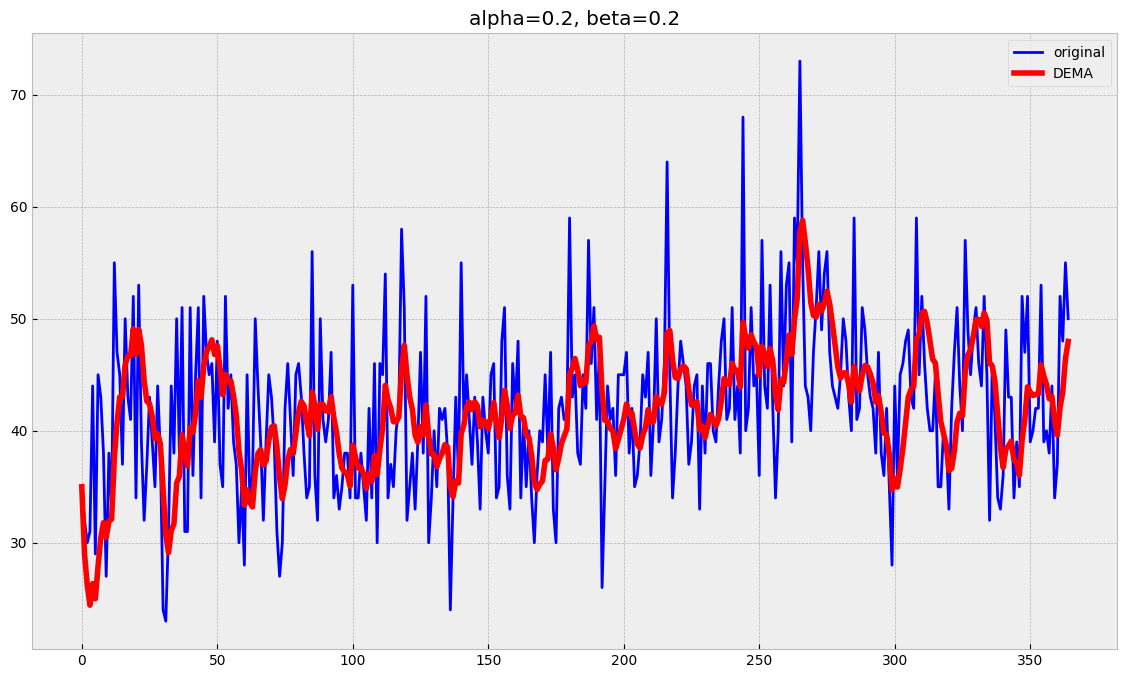

In [32]:
plot_dema(st, 0.2, 0.2)

2.b) Усредним нестационарный временной ряд при помощи TEMA.

In [53]:
def initial_trend(i, series, season_len):
    return sum([float(series.iloc[i + season_len] - series.iloc[i]) / season_len]) / season_len

In [54]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series.iloc[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series.iloc[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [55]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series.iloc[0]
            trend = initial_trend(i, series, slen)
            result.append(series.iloc[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series.iloc[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [56]:
def plot_tema(alpha, beta, gamma, ser=nst["Count"], ser_to_plot=nst["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

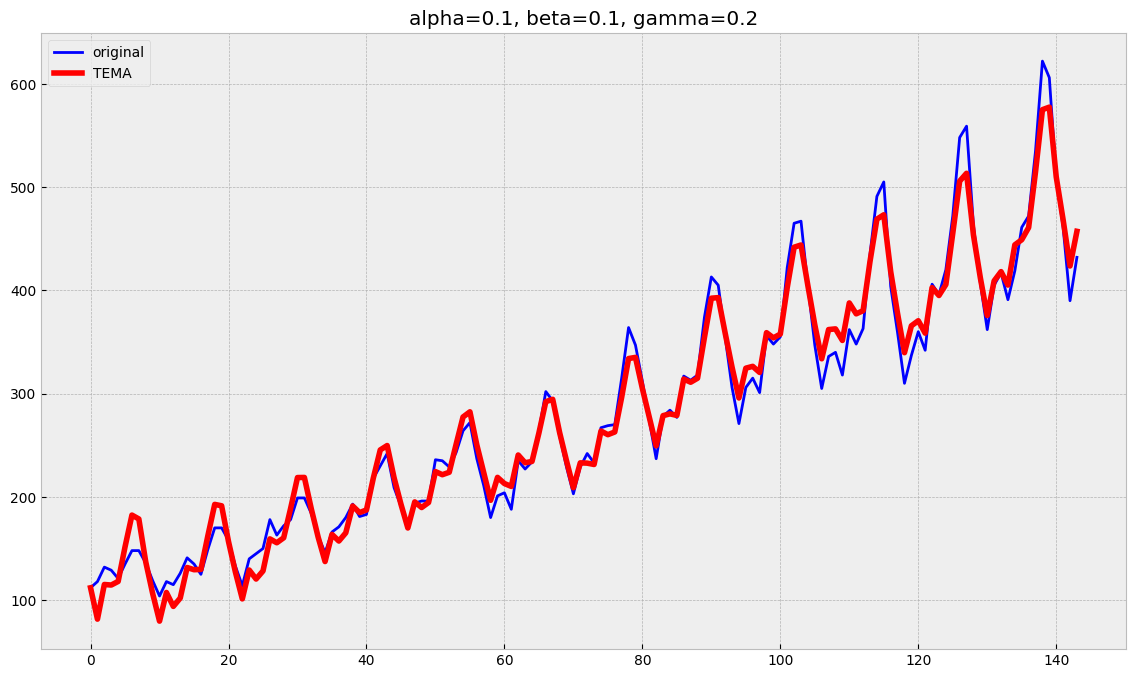

In [58]:
plot_tema(0.1, 0.1, 0.2, n_preds=0)

3)Оценим качество.

a) Для стационарного ряда.

In [66]:
st_mse = np.mean((st['Count'] - double_ema(st['Count'], alpha=0.1, beta=0.1)) ** 2)
st_mse

57.193842040759385

b) Для нестационарного временного ряда.

In [67]:
nst_mse = np.mean((nst['Count'] - triple_exponential_smoothing(nst['Count'], slen=12, alpha=0.1, beta=0.1, gamma=0.2, n_preds=0)) ** 2)
nst_mse

280.6584664124164

Для нестационарного временного ряда была выбрана модель TEMA, т. к. имеется ярко выраженная сезонность. В свою очередь, для стационарного временного ряда выбрана модель DEMA, т.к. сезонность отсутствует, ввиду стационарности временного ряда.